In [1]:
import numpy as np
from numpy.random import seed
seed(42)

from absl import app
from absl import flags

import tensorflow as tf
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split

from mia.estimators import ShadowModelBundle, AttackModelBundle, prepare_attack_data

In [5]:
NUM_CLASSES = 10
WIDTH = 32
HEIGHT = 32
CHANNELS = 3
SHADOW_DATASET_SIZE = 1000
ATTACK_TEST_DATASET_SIZE = 4000


target_epochs = 12
attack_epochs = 12
num_shadows = 10

In [6]:
def get_data():
    """Prepare CIFAR10 data."""
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
    y_train = tf.keras.utils.to_categorical(y_train)
    y_test = tf.keras.utils.to_categorical(y_test)
    X_train = X_train.astype("float32")[:10000]
    X_test = X_test.astype("float32")
    y_train = y_train.astype("float32")[:10000]
    y_test = y_test.astype("float32")
    X_train /= 255
    X_test /= 255
    return (X_train, y_train), (X_test, y_test)

def target_model_fn():
    """The architecture of the target (victim) model.

    The attack is white-box, hence the attacker is assumed to know this architecture too."""

    model = tf.keras.models.Sequential()

    model.add(
        layers.Conv2D(
            32,
            (3, 3),
            activation="tanh",
            padding="same",
            input_shape=(WIDTH, HEIGHT, CHANNELS),
        )
    )
    #model.add(layers.Conv2D(32, (3, 3), activation="tanh"))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    #model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(64, (3, 3), activation="tanh", padding="same"))
    #model.add(layers.Conv2D(64, (3, 3), activation="tanh"))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    #model.add(layers.Dropout(0.25))

    model.add(layers.Flatten())

    model.add(layers.Dense(128, activation="tanh"))
    #model.add(layers.Dropout(0.5))

    model.add(layers.Dense(NUM_CLASSES, activation="softmax"))
    model.compile("adam", loss="categorical_crossentropy", metrics=["accuracy"])

    return model

def attack_model_fn():
    """Attack model that takes target model predictions and predicts membership.

    Following the original paper, this attack model is specific to the class of the input.
    AttachModelBundle creates multiple instances of this model for each class.
    """
    model = tf.keras.models.Sequential()

    model.add(layers.Dense(128, activation="relu", input_shape=(NUM_CLASSES,)))

    model.add(layers.Dropout(0.3, noise_shape=None, seed=None))
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dropout(0.2, noise_shape=None, seed=None))
    model.add(layers.Dense(64, activation="relu"))

    model.add(layers.Dense(1, activation="sigmoid"))
    model.compile("adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

In [7]:
(X_train, y_train), (X_test, y_test) = get_data()

# Train the target model.
print("Training the target model...")
target_model = target_model_fn()
target_model.fit(X_train, y_train, epochs=target_epochs, verbose=True)

Training the target model...


W0623 11:20:37.991618 4531553728 deprecation.py:323] From /anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/resource_variable_ops.py:435: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.
W0623 11:20:38.274591 4531553728 deprecation.py:323] From /anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Epoch 1/12
10000/10000 [==============================] - 13s 1ms/sample - loss: 1.6717 - acc: 0.4079
Epoch 2/12
10000/10000 [==============================] - 14s 1ms/sample - loss: 1.2988 - acc: 0.5448
Epoch 3/12
10000/10000 [==============================] - 16s 2ms/sample - loss: 1.1126 - acc: 0.6136
Epoch 4/12
10000/10000 [==============================] - 13s 1ms/sample - loss: 0.9766 - acc: 0.6569
Epoch 5/12
10000/10000 [==============================] - 13s 1ms/sample - loss: 0.8535 - acc: 0.7009
Epoch 6/12
10000/10000 [==============================] - 12s 1ms/sample - loss: 0.7114 - acc: 0.7503
Epoch 7/12
10000/10000 [==============================] - 11s 1ms/sample - loss: 0.5691 - acc: 0.8085
Epoch 8/12
10000/10000 [==============================] - 12s 1ms/sample - loss: 0.4375 - acc: 0.8585
Epoch 9/12
10000/10000 [==============================] - 12s 1ms/sample - loss: 0.3035 - acc: 0.9140
Epoch 10/12
10000/10000 [==============================] - 12s 1ms/sample - loss: 

In [5]:
target_model.save("target_cifar10.h5")

In [7]:
from tensorflow.keras.models import load_model

target_model = load_model('target_cifar10.h5')


In [8]:
# Train the shadow models.
smb = ShadowModelBundle(
    target_model_fn,
    shadow_dataset_size=SHADOW_DATASET_SIZE,
    num_models=num_shadows
)

# We assume that attacker's data were not seen in target's training.
attacker_X_train, attacker_X_test, attacker_y_train, attacker_y_test = train_test_split(
    X_test, y_test, test_size=0.5)
print(attacker_X_train.shape, attacker_X_test.shape)

print("Training the shadow models...")
X_shadow, y_shadow = smb.fit_transform(
    attacker_X_train,
    attacker_y_train,
    fit_kwargs=dict(
        epochs=target_epochs,
        verbose=True,
        validation_data=(attacker_X_test, attacker_y_test)
    )
)

(5000, 32, 32, 3) (5000, 32, 32, 3)
Training the shadow models...
Train on 1000 samples, validate on 5000 samples
Epoch 1/12
1000/1000 [==============================] - 4s 4ms/sample - loss: 2.1298 - acc: 0.2310 - val_loss: 1.8818 - val_acc: 0.3224
Epoch 2/12
1000/1000 [==============================] - 4s 4ms/sample - loss: 1.6593 - acc: 0.4110 - val_loss: 1.7882 - val_acc: 0.3696
Epoch 3/12
1000/1000 [==============================] - 5s 5ms/sample - loss: 1.4822 - acc: 0.4840 - val_loss: 1.7762 - val_acc: 0.3734
Epoch 4/12
1000/1000 [==============================] - 4s 4ms/sample - loss: 1.3516 - acc: 0.5310 - val_loss: 1.7583 - val_acc: 0.3836
Epoch 5/12
1000/1000 [==============================] - 4s 4ms/sample - loss: 1.1795 - acc: 0.6000 - val_loss: 1.7253 - val_acc: 0.3960
Epoch 6/12
1000/1000 [==============================] - 3s 3ms/sample - loss: 1.0594 - acc: 0.6320 - val_loss: 1.7342 - val_acc: 0.4178
Epoch 7/12
1000/1000 [==============================] - 4s 4ms/sample 

Epoch 11/12
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.4650 - acc: 0.8740 - val_loss: 1.9786 - val_acc: 0.4182
Epoch 12/12
1000/1000 [==============================] - 4s 4ms/sample - loss: 0.3555 - acc: 0.9270 - val_loss: 2.0003 - val_acc: 0.4196
Train on 1000 samples, validate on 5000 samples
Epoch 1/12
1000/1000 [==============================] - 4s 4ms/sample - loss: 2.2084 - acc: 0.2200 - val_loss: 1.8727 - val_acc: 0.3340
Epoch 2/12
1000/1000 [==============================] - 3s 3ms/sample - loss: 1.6669 - acc: 0.4330 - val_loss: 1.7520 - val_acc: 0.3850
Epoch 3/12
1000/1000 [==============================] - 3s 3ms/sample - loss: 1.5027 - acc: 0.4850 - val_loss: 1.7586 - val_acc: 0.3882
Epoch 4/12
1000/1000 [==============================] - 3s 3ms/sample - loss: 1.3531 - acc: 0.5350 - val_loss: 1.7296 - val_acc: 0.3824
Epoch 5/12
1000/1000 [==============================] - 4s 4ms/sample - loss: 1.2241 - acc: 0.5680 - val_loss: 1.7303 - val_acc: 0.404

1000/1000 [==============================] - 3s 3ms/sample - loss: 0.6094 - acc: 0.8150 - val_loss: 1.8389 - val_acc: 0.4262
Epoch 10/12
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.4876 - acc: 0.8690 - val_loss: 1.8642 - val_acc: 0.4288
Epoch 11/12
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.3661 - acc: 0.9150 - val_loss: 1.9316 - val_acc: 0.4240
Epoch 12/12
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.2521 - acc: 0.9590 - val_loss: 1.9792 - val_acc: 0.4356


In [10]:
from sklearn.metrics import classification_report

# ShadowModelBundle returns data in the format suitable for the AttackModelBundle.
amb = AttackModelBundle(attack_model_fn, num_classes=NUM_CLASSES)

# Fit the attack models.
print("Training the attack models...")
amb.fit(
    X_shadow, y_shadow, fit_kwargs=dict(epochs=attack_epochs, verbose=True)
)

W0623 11:32:50.499297 4531553728 deprecation.py:506] From /anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/layers/core.py:143: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Training the attack models...
Epoch 1/12
2082/2082 [==============================] - 1s 253us/sample - loss: 0.5789 - acc: 0.7502
Epoch 2/12
2082/2082 [==============================] - 0s 61us/sample - loss: 0.4755 - acc: 0.7795
Epoch 3/12
2082/2082 [==============================] - 0s 61us/sample - loss: 0.4718 - acc: 0.7829
Epoch 4/12
2082/2082 [==============================] - 0s 55us/sample - loss: 0.4714 - acc: 0.7800
Epoch 5/12
2082/2082 [==============================] - 0s 51us/sample - loss: 0.4682 - acc: 0.7786
Epoch 6/12
2082/2082 [==============================] - 0s 54us/sample - loss: 0.4649 - acc: 0.7776
Epoch 7/12
2082/2082 [==============================] - 0s 55us/sample - loss: 0.4666 - acc: 0.7824
Epoch 8/12
2082/2082 [==============================] - 0s 58us/sample - loss: 0.4655 - acc: 0.7776
Epoch 9/12
2082/2082 [==============================] - 0s 57us/sample - loss: 0.4681 - acc: 0.7781
Epoch 10/12
2082/2082 [==============================] - 0s 63us/samp

2031/2031 [==============================] - 0s 55us/sample - loss: 0.4844 - acc: 0.7750
Epoch 11/12
2031/2031 [==============================] - 0s 72us/sample - loss: 0.4786 - acc: 0.7789
Epoch 12/12
2031/2031 [==============================] - 0s 65us/sample - loss: 0.4767 - acc: 0.7755
Epoch 1/12
2021/2021 [==============================] - 1s 267us/sample - loss: 0.5699 - acc: 0.7501
Epoch 2/12
2021/2021 [==============================] - 0s 60us/sample - loss: 0.4595 - acc: 0.7853
Epoch 3/12
2021/2021 [==============================] - 0s 61us/sample - loss: 0.4470 - acc: 0.7917
Epoch 4/12
2021/2021 [==============================] - 0s 59us/sample - loss: 0.4439 - acc: 0.7907
Epoch 5/12
2021/2021 [==============================] - 0s 60us/sample - loss: 0.4442 - acc: 0.7952
Epoch 6/12
2021/2021 [==============================] - 0s 60us/sample - loss: 0.4424 - acc: 0.7976
Epoch 7/12
2021/2021 [==============================] - 0s 60us/sample - loss: 0.4399 - acc: 0.7912
Epoch 8/

In [11]:
amb.save('attack_model.h5')

AttributeError: 'AttackModelBundle' object has no attribute 'save'

In [18]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Test the success of the attack.
# Prepare examples that were in the training, and out of the training.
data_in = X_train[:ATTACK_TEST_DATASET_SIZE], y_train[:ATTACK_TEST_DATASET_SIZE]
data_out = attacker_X_test[:ATTACK_TEST_DATASET_SIZE], attacker_y_test[:ATTACK_TEST_DATASET_SIZE]

# Compile them into the expected format for the AttackModelBundle.
attack_test_data, real_membership_labels = prepare_attack_data(
    target_model, data_in, data_out
)

# Compute the attack accuracy.
attack_guesses = amb.predict(attack_test_data)
attack_accuracy = np.mean(attack_guesses == real_membership_labels)

print(attack_accuracy)
print (classification_report(real_membership_labels, attack_guesses))

fpr, tpr, thresholds = roc_curve(real_membership_labels, attack_guesses)
auc_non_federated = auc(fpr, tpr)

0.73125
             precision    recall  f1-score   support

        0.0       0.99      0.47      0.63      4000
        1.0       0.65      0.99      0.79      4000

avg / total       0.82      0.73      0.71      8000



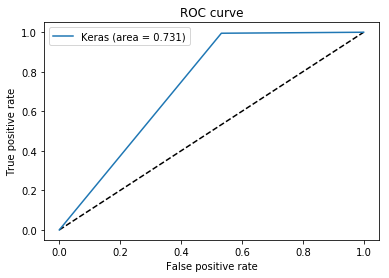

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc_non_federated))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()